In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from decimate.decimate import incremental_decimation, make_trimesh, pimp_meshes, twisty_viz, dump_mp4
from decimate.getdata import get_area

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Fetch elevation data for Half Dome at 50m resolution (opentopodata.org API)
#
# `get_area` requests chunks of 100 points and saves each as a csv file in
# the `csv_chunks` folder, allowing big requests to be resumed if
# interrupted. `corners` are latitude and longitude (have to use Google 
# Maps or your favorite gps app to find these points)
corners = [(37.7500, -119.5430), (37.7390, -119.5280)]
data = get_area(corners=corners, stride=50)
data.to_csv('data_halfdomecrop_srtm30m_0050m.csv', float_format='%8.4f')
print(data.head())

## can load from file if everything was already downloaded
#data = pd.read_csv('data_halfdomecrop_srtm30m_0050m.csv', index_col=0)

REQUESTING 675 elevation points
  HAVE csv_chunks/data_e7ffe957_0000.csv
  HAVE csv_chunks/data_e7ffe957_0001.csv
  HAVE csv_chunks/data_e7ffe957_0002.csv
  HAVE csv_chunks/data_e7ffe957_0003.csv
  HAVE csv_chunks/data_e7ffe957_0004.csv
  HAVE csv_chunks/data_e7ffe957_0005.csv
  HAVE csv_chunks/data_e7ffe957_0006.csv
   dataset  elevation  location.lat  location.lng    y    x  ix  iy
0  srtm30m     2155.0        37.739   -119.543000 -600 -649   0   0
1  srtm30m     2152.0        37.739   -119.542432 -600 -600   1   0
2  srtm30m     2150.0        37.739   -119.541864 -600 -550   2   0
3  srtm30m     2153.0        37.739   -119.541296 -600 -500   3   0
4  srtm30m     2153.0        37.739   -119.540728 -600 -450   4   0


In [3]:
# set parameters for decimation and visualization
decimation_steps = 30        # 30 meshes total in the decimation sequence
decimation_min = 100         # the last mesh will have 100 faces
viz_opts = dict(
    colormap=plt.cm.winter,  # mesh vertices (colored by elevation)
    bg_color=[20, 20, 30],   # background color
    twist_axis='y',          # twist around this axis
    twist_angle=15,          # twist back and forth this much (degrees)
    num_frames=400,          # frames in the animation sequence
    azimuth=240,             # rotate so that view is looking 0=North, 90=West, 180=South, 270=East
    tilt=10                  # tilt the elevation (data-z) axis towards the viewer (degrees)
)

In [4]:
# build the sequence of decimated meshes
mesh = make_trimesh(data[['x', 'y', 'elevation']].values)
meshes = incremental_decimation(mesh, decimation_min, decimation_steps)

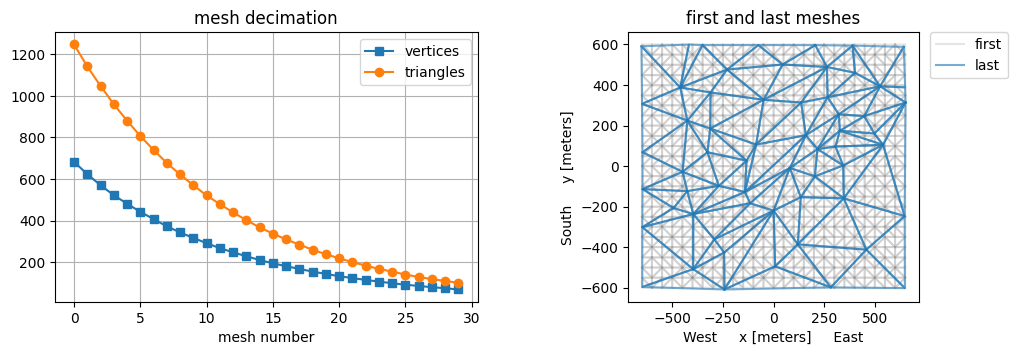

In [5]:
# plot some mesh properties
vertices = [len(np.array(x.vertices)) for x in meshes]
triangles = [len(np.array(x.triangles)) for x in meshes]
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 3.5))

_ = axs[0].plot(np.arange(decimation_steps), vertices, '-s', label='vertices')
_ = axs[0].plot(np.arange(decimation_steps), triangles, '-o', label='triangles')
axs[0].legend()
axs[0].grid()
axs[0].set_title('mesh decimation')
_ = axs[0].set_xlabel('mesh number')

def plt_2dmesh(mesh, ax, color, alpha=1, label='None'):
    ver = np.array(mesh.vertices)
    tri = np.array(mesh.triangles)
    tri = np.hstack((tri, tri))
    for i, t in enumerate(tri):
        xyz = ver[t[:4], :]
        label = label if i==0 else None
        ax.plot(xyz[:, 0], xyz[:, 1], '-', color=color, alpha=alpha, label=label)

plt_2dmesh(meshes[0], axs[1], 'grey', alpha=0.2, label='first')
plt_2dmesh(meshes[-1], axs[1], 'tab:blue', alpha=0.6, label='last')
axs[1].set_aspect('equal')
_ = axs[1].legend(bbox_to_anchor=(1.04, 1), loc="upper left", borderaxespad=0)
_ = axs[1].set_title('first and last meshes')
_ = axs[1].set_xlabel('West     x [meters]     East')
_ = axs[1].set_ylabel('South     y [meters]     ')
    

In [6]:
# set mesh colors and orientations prior to launching the GUI
pimped = pimp_meshes(meshes, **viz_opts)

# Launching the GUI
# Pressing `h` prints a help menu of keyboard shortcuts
# Pressing `c` captures animation sequence frames and returns them as `mov`
# Pressing `space` pauses/resumes the animation
mov = twisty_viz(pimped, **viz_opts)

#----------------------------------------------------------------
# launching mesh animation with the following properties
#--------
# number of meshes        : 30
# frames per anim cycle   : 400
# twist axis              : y
# twist step size    [deg]: 0.43633231299858233
# twist angle        [deg]: 15
# field of view      [deg]: 35.0
#----------------------------------------------------------------
# capturing the next animation sweep!
# output mov dims         : (400, 640, 640, 3)
# output mov raw size [MB]: 468.75
# start capture
# capture frame: 399
# done capture
#--------


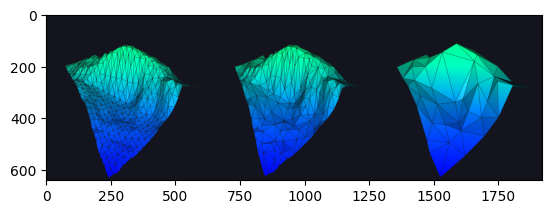

In [7]:
# if the animation was captured, view some frames
_ = plt.imshow(np.hstack((mov[0], mov[100], mov[200])))

In [ ]:
# export the animation sequence to a movie
dump_mp4(mov, output_filename='movie.mp4')

In [ ]:
%%bash
vlc movie.mp4 &>/dev/null